In [3]:
import pandas as pd
import json
import numpy as np
from pandas.io.json import json_normalize
import copy 
import seaborn as sns


# Data processing summary

* drop campaign - 96% missing
* drop socialEngType - 100% missing
* drop medium - (other 16% missing) - similar to channelGrouping
* clean source - drop rows with keywords listed below and dbots
  * mall.googleplex.com
  * analytics.google.com
  * bots - 60 entries only
* drop keyword 
* drop adwordsClickInfo.criteriaParameters - 100% missing 
* clean isTrueDirect - CHANGE N/A TO FALSE
* drop campaigncode, browswerversion, browswersize,operatingSystemVersion - 100% missing 
* drop mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution - 100% missing 
* drop cityId,latitude,longitude,networkLocation - 100% missing
* drop referalPath - 72% missing  
* drop adwordsClickInfo.isVideoAd 
* drop adwordsClickInfo.adNetworkType, adwordsClickInfo.slot, adwordsClickInfo.gclId, adContent - 97% missing - not relevant to revenue
* drop adwordsClickInfo.page - fillna with 0 as no interaction with ads 
* clean channelgrouping
  * label-encoding
  * one-hot-encoding
  * Groupby visitor and columns by count of each source.

## Read in data, specify json columns for further flatten out

In [ ]:
JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
df_train = pd.read_csv('train.csv', 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}) # Important!!

In [ ]:
JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
df_test = pd.read_csv('test.csv', 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}) # Important!!

In [ ]:
df_train['set'] = 'train'
df_test['set'] = 'test'

In [ ]:
frames = [df_train,df_test]
df = pd.concat(frames)

## Flatten JSON colums

In [ ]:
devices_flatten = json_normalize(df['device'])

In [ ]:
geoNetwork_flatten = json_normalize(df['geoNetwork'])

In [ ]:
totals_flatten = json_normalize(df['totals'])

In [ ]:
trafficSource_flatten = json_normalize(df['trafficSource'])

In [ ]:
trafficSource_flatten.head()

In [ ]:
df = df.merge(trafficSource_flatten, right_index=True, left_index = True)

In [ ]:
df = df.merge(devices_flatten, right_index=True, left_index = True)
df = df.merge(geoNetwork_flatten, right_index=True, left_index = True)
df = df.merge(totals_flatten, right_index=True, left_index = True)

In [ ]:
JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
df = df.drop(JSON_COLUMNS, axis = 1)

In [ ]:
devices_flatten.shape[1]+trafficSource_flatten.shape[1]+geoNetwork_flatten.shape[1]+totals_flatten.shape[1]+12

In [16]:
df.to_csv('all_flatten_data.csv')

## Read in flatten_Data

In [33]:
raw = pd.read_csv('all_flatten_data.csv')
pd.set_option("display.max_columns",None)

/Users/jiahui/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Train set: 
We have 903,653 sessions, 723,803 unique visitors. Within it, 11,515 records has transactions which include 10,114 (87%) unique visitors.

### Total:
We have 1,708,337 sessions, 1,323,730 unique visitors. 

In [19]:
np.count_nonzero(df.fullVisitorId.unique())

1323730

In [63]:
#11515 rows has transactions
has_transactions = df.loc[df.transactionRevenue.notnull()]
has_transactions.count()

channelGrouping                        21758
date                                   21758
fullVisitorId                          21758
sessionId                              21758
socialEngagementType                   21758
visitId                                21758
visitNumber                            21758
visitStartTime                         21758
set                                    21758
campaign                               21758
source                                 21758
medium                                 21758
keyword                                 7282
adwordsClickInfo.criteriaParameters    21758
isTrueDirect                           13235
referralPath                           10271
adwordsClickInfo.page                    854
adwordsClickInfo.slot                    854
adwordsClickInfo.gclId                   858
adwordsClickInfo.adNetworkType           854
adwordsClickInfo.isVideoAd               854
adContent                                262
campaignCo

In [64]:
np.count_nonzero(has_transactions.fullVisitorId.unique())

20409

In [107]:
df.dtypes

channelGrouping        object
date                   object
fullVisitorId          object
visitId                 int64
visitNumber             int64
visitStartTime          int64
set                    object
source                 object
medium                 object
isTrueDirect           object
referralPath           object
campaignCode           object
browser                object
browserVersion         object
operatingSystem        object
isMobile                 bool
deviceCategory         object
continent              object
subContinent           object
country                object
region                 object
metro                  object
city                   object
networkDomain          object
hits                  float64
pageviews             float64
bounces               float64
newVisits             float64
transactionRevenue    float64
fake_traffic            int64
ctadwords               int64
browser_new            object
weekdays               object
visit_hour

## Convert "string" variables to float

In [105]:
str_float = ['hits','pageviews', 'bounces', 'newVisits', 'transactionRevenue']

def to_float(data, str_float):
    for i in str_float:
        data[i] = data[i].astype(float)
        #return df
        

In [106]:
to_float(df, str_float)

### To see the unique levels of data, if the data only have one level then delete it

In [69]:
dct = {i: df[i].unique() for i in df.columns}

In [97]:
df.groupby('browser').transactionRevenue.count()

browser
(not set)                                          0
0                                                  0
ADM                                                0
Amazon Silk                                        2
Android Browser                                    0
Android Runtime                                    0
Android Webview                                   11
Apple-iPhone7C2                                    0
BlackBerry                                         0
CSM Click                                          0
Changa 99695759                                    0
Chrome                                         19586
Coc Coc                                            0
DASH_JR_3G                                         0
DoCoMo                                             0
Edge                                             106
Firefox                                          354
HTC802t_TD                                         0
Hisense M20-M_LTE                     

In [72]:
pd.set_option('display.max_rows',99)
df.groupby(['bounces','browser']).newVisits.count()

bounces  browser                   
1.0      (not set)                          9
         0                                 14
         Amazon Silk                      391
         Android Browser                  603
         Android Runtime                    3
         Android Webview                 7427
         Apple-iPhone7C2                   18
         BlackBerry                       238
         CSM Click                          1
         Changa 99695759                    2
         Chrome                        427278
         Coc Coc                          955
         DASH_JR_3G                         0
         Edge                            9309
         Firefox                        37211
         Hisense M20-M_LTE                  2
         Internet Explorer              20805
         Iron                              33
         Konqueror                          2
         LYF_LS_4002_11                     2
         LYF_LS_4002_12                     

In [23]:
drop_columns = ['socialEngagementType', 'campaign','keyword','adwordsClickInfo.criteriaParameters','adwordsClickInfo.criteriaParameters',
                'browserSize', 'operatingSystemVersion', 'mobileDeviceBranding','mobileInputSelector', 'mobileDeviceInfo',
                'mobileDeviceMarketingName', 'flashVersion','language','screenColors','screenResolution', 'cityId','latitude',
                'longitude','networkLocation','visits','sessionId','adwordsClickInfo.isVideoAd','mobileDeviceModel','adwordsClickInfo.adNetworkType', 
                'adwordsClickInfo.slot', 'adContent','adwordsClickInfo.page'
               ]

In [24]:
df.drop(drop_columns, axis = 1, inplace = True)

In [26]:
df['newVisits'].fillna(0,inplace=True)
df['bounces'].fillna(0,inplace=True)
df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,set,source,medium,isTrueDirect,...,country,region,metro,city,networkDomain,hits,pageviews,bounces,newVisits,transactionRevenue
0,Organic Search,20160902,1131660440785968503,1472830385,1,1472830385,train,google,organic,NaN,...,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1,1,1,1,NaN
0,Organic Search,20171016,6167871330617112363,1508151024,2,1508151024,test,google,organic,NaN,...,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1,1,1,1,NaN
1,Organic Search,20160902,377306020877927890,1472880147,1,1472880147,train,google,organic,NaN,...,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1,1,1,1,NaN
1,Organic Search,20171016,0643697640977915618,1508175522,1,1508175522,test,google,organic,NaN,...,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1,1,1,1,NaN
2,Organic Search,20160902,3895546263509774583,1472865386,1,1472865386,train,google,organic,NaN,...,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,1,1,1,1,NaN


### Sessions that have sourse including "analytics.google.com", 'gist.github.com' are the testing sessions, create a fake_session indicator.

In [29]:
#source from GA doesn't have transactions
fake_source = ['analytics','github','online-metrics.com','lunametrics.com','optimize.google.com','productforums.google.com',
              'adwords.google.com','sandbox.google.com','corp.google.com','google.cl','datastudio.google.com','marketingland.com',
              'adwords-displayads.googleusercontent.com','localhost','business.facebook.com','adwords-next-devel.qa.adz.google.com',
              'borg.google']

# total = 0
# count = 0
# for i in fake_source:
#     if df.source.str.contains(i).count() > 0:
#         count += df[df.source.str.contains(i)].count()[1]
#         total += df[df.source.str.contains(i)].transactionRevenue.sum() 
# print(total)
# print(count)
        #df[df.source.str.contains('analytics')].transactionRevenue.sum()

In [30]:
# create a column for fake traffic
df['fake_traffic'] = 0

In [31]:
for i in fake_source:
    df.loc[df.source.str.contains(i),'fake_traffic'] = 1 
    
df.loc[df['fake_traffic'] ==1].count()[1]

33771

### After filtering the fake source, we found we have 33,771 fake sessions that comes from web developement, google internal or third party tracking tool.

### Create campaign indicator by glickid, and count how many times this gclickid came to the store

In [71]:
#if ['adwordsClickInfo.gclId'] = Flase 1,0
#df['adwordsClickInfo.gclId'] = raw['adwordsClickInfo.gclId']

In [72]:
df['ctadwords'] = 0
df.loc[~df['adwordsClickInfo.gclId'].isna(),'ctadwords'] = 1

In [76]:
df[df.ctadwords == 1].head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,set,source,medium,isTrueDirect,referralPath,campaignCode,browser,browserVersion,operatingSystem,isMobile,deviceCategory,continent,subContinent,country,region,metro,city,networkDomain,hits,pageviews,bounces,newVisits,transactionRevenue,fake_traffic,ctadwords,adwordsClickInfo.gclId
204,Affiliates,20160902,2903318777294784357,1472826827,1,1472826827,train,Partners,affiliate,NaN,NaN,NaN,Chrome,not available in demo dataset,Windows,False,desktop,Europe,Eastern Europe,Russia,not available in demo dataset,not available in demo dataset,not available in demo dataset,itcom-tula.ru,1,1,1,1,NaN,0,1,Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRBVDYwnFaw...
204,Organic Search,20171016,7998039051638733661,1508174789,10,1508174789,test,Partners,affiliate,NaN,NaN,NaN,Chrome,not available in demo dataset,Windows,False,desktop,Europe,Eastern Europe,Russia,not available in demo dataset,not available in demo dataset,not available in demo dataset,itcom-tula.ru,1,1,1,1,NaN,0,1,Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRBVDYwnFaw...
205,Affiliates,20160902,8094671042653767256,1472807005,1,1472807005,train,Partners,affiliate,NaN,NaN,NaN,Safari,not available in demo dataset,iOS,True,tablet,Oceania,Australasia,Australia,Queensland,(not set),Brisbane,comindico.com.au,1,1,1,1,NaN,0,1,Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRBVDYwnFaw...
205,Organic Search,20171016,436559266546047609,1508191674,1,1508191674,test,Partners,affiliate,NaN,NaN,NaN,Safari,not available in demo dataset,iOS,True,tablet,Oceania,Australasia,Australia,Queensland,(not set),Brisbane,comindico.com.au,1,1,1,1,NaN,0,1,Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRBVDYwnFaw...
542,Organic Search,20160902,1611453642221139587,1472877064,1,1472877064,train,google,organic,NaN,NaN,NaN,Chrome,not available in demo dataset,Windows,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Santa Clara,(not set),6,5,0,1,NaN,0,1,Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRAq0D2zir1...


In [77]:
df.drop('adwordsClickInfo.gclId', axis = 1, inplace = True)

### Create browser types, merge into 6 categories ['Chrome', 'Firefox','Internet Explorer', 'Safari'&'Safari (in-app)','Edge','other']

In [ ]:
#'browser'['Chrome', 'Firefox','Internet Explorer', 'Safari','Safari (in-app)','Edge','other']

In [79]:
df['browser_new'] = 'other'
for i in ['Chrome', 'Firefox','Internet Explorer', 'Safari','Safari (in-app)','Edge']:
    df.loc[df['browser'] == i,'browser_new'] = i

Change NaN Values in isTrueDirect to FALSE

In [80]:
df['isTrueDirect'].fillna('FALSE', inplace=True)

In [82]:
df['date'] = df['date'].astype(str)

### Get visit times by weekdays and hours, but be aware of the hour might be local or user's hour

In [83]:
import datetime
df['weekdays'] = [datetime.datetime.strptime(i, '%Y%m%d').strftime('%A') for i in df['date'].values]
df['weekdays'].unique()

array(['Friday', 'Monday', 'Thursday', 'Sunday', 'Saturday', 'Tuesday',
       'Wednesday'], dtype=object)

In [85]:
df['visit_hour'] = [datetime.datetime.fromtimestamp(i).hour for i in df.visitStartTime]

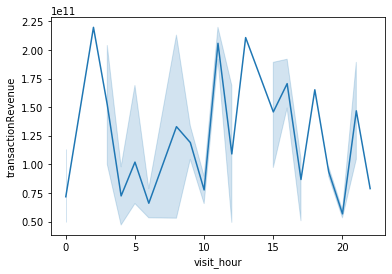

In [109]:
# to see if any hour peaks for sales
sns.lineplot(df['visit_hour'], df.groupby('visit_hour').transactionRevenue.sum())

### Create dummy columns, the dummy base is in the dummy_base list

In [110]:
dummy_cols = ['channelGrouping','isTrueDirect','deviceCategory','browser_new','subContinent','operatingSystem',
             'isMobile','weekdays','visit_hour']
not_dropfirst_cols = set(pd.get_dummies(data=df, columns=dummy_cols).columns)
dropfirst_cols = set(pd.get_dummies(data=df, columns=dummy_cols, drop_first = True).columns)
dummy_base = not_dropfirst_cols.difference(dropfirst_cols)

In [111]:
dummy_base

{'browser_new_Chrome',
 'channelGrouping_(Other)',
 'deviceCategory_desktop',
 'isMobile_False',
 'isTrueDirect_True',
 'operatingSystem_(not set)',
 'subContinent_(not set)',
 'visit_hour_0',
 'weekdays_Friday'}

### Drop the extra columns

In [113]:
drop_cols = ['visitStartTime','source','medium','referralPath',
             'campaignCode','browser','browserVersion','continent',
             'country','region','metro','city','networkDomain',]
#left date, visitId 
#df_dummies.drop(drop_cols, axis = 1, inplace = True)

In [123]:
df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'set', 'source', 'medium', 'isTrueDirect',
       'referralPath', 'campaignCode', 'browser', 'browserVersion',
       'operatingSystem', 'isMobile', 'deviceCategory', 'continent',
       'subContinent', 'country', 'region', 'metro', 'city', 'networkDomain',
       'hits', 'pageviews', 'bounces', 'newVisits', 'transactionRevenue',
       'fake_traffic', 'ctadwords', 'browser_new', 'weekdays', 'visit_hour'],
      dtype='object')

In [127]:
drop_cols = ['date','visitId','visitStartTime','medium','referralPath','campaignCode','browser', 'browserVersion',
            'continent','country', 'region', 'metro', 'city', 'networkDomain']
df.drop(drop_cols, axis = 1, inplace = True)

In [128]:
df.columns

Index(['channelGrouping', 'fullVisitorId', 'visitNumber', 'set', 'source',
       'isTrueDirect', 'operatingSystem', 'isMobile', 'deviceCategory',
       'subContinent', 'hits', 'pageviews', 'bounces', 'newVisits',
       'transactionRevenue', 'fake_traffic', 'ctadwords', 'browser_new',
       'weekdays', 'visit_hour'],
      dtype='object')

In [129]:
df_dummies = pd.get_dummies(data=df, columns=dummy_cols, drop_first = True)

In [132]:
df_dummies.head(2)

,fullVisitorId,visitNumber,set,source,hits,pageviews,bounces,newVisits,transactionRevenue,fake_traffic,ctadwords,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,isTrueDirect_FALSE,deviceCategory_mobile,deviceCategory_tablet,browser_new_Edge,browser_new_Firefox,browser_new_Internet Explorer,browser_new_Safari,browser_new_Safari (in-app),browser_new_other,subContinent_Australasia,subContinent_Caribbean,subContinent_Central America,subContinent_Central Asia,subContinent_Eastern Africa,subContinent_Eastern Asia,subContinent_Eastern Europe,subContinent_Melanesia,subContinent_Micronesian Region,subContinent_Middle Africa,subContinent_Northern Africa,subContinent_Northern America,subContinent_Northern Europe,subContinent_Polynesia,subContinent_South America,subContinent_Southeast Asia,subContinent_Southern Africa,subContinent_Southern Asia,subContinent_Southern Europe,subContinent_Western Africa,subContinent_Western Asia,subContinent_Western Europe,operatingSystem_Android,operatingSystem_BlackBerry,operatingSystem_Chrome OS,operatingSystem_Firefox OS,operatingSystem_FreeBSD,operatingSystem_Linux,operatingSystem_Macintosh,operatingSystem_NTT DoCoMo,operatingSystem_Nintendo 3DS,operatingSystem_Nintendo Wii,operatingSystem_Nintendo WiiU,operatingSystem_Nokia,operatingSystem_OpenBSD,operatingSystem_Samsung,operatingSystem_SunOS,operatingSystem_Windows,operatingSystem_Windows Phone,operatingSystem_Xbox,operatingSystem_iOS,isMobile_True,weekdays_Monday,weekdays_Saturday,weekdays_Sunday,weekdays_Thursday,weekdays_Tuesday,weekdays_Wednesday,visit_hour_1,visit_hour_2,visit_hour_3,visit_hour_4,visit_hour_5,visit_hour_6,visit_hour_7,visit_hour_8,visit_hour_9,visit_hour_10,visit_hour_11,visit_hour_12,visit_hour_13,visit_hour_14,visit_hour_15,visit_hour_16,visit_hour_17,visit_hour_18,visit_hour_19,visit_hour_20,visit_hour_21,visit_hour_22,visit_hour_23
0,1131660440785968503,1,train,google,1.0,1.0,1.0,1.0,NaN,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
0,6167871330617112363,2,test,google,1.0,1.0,1.0,1.0,NaN,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [133]:
df_dummies.columns

Index(['fullVisitorId', 'visitNumber', 'set', 'source', 'hits', 'pageviews',
       'bounces', 'newVisits', 'transactionRevenue', 'fake_traffic',
       'ctadwords', 'channelGrouping_Affiliates', 'channelGrouping_Direct',
       'channelGrouping_Display', 'channelGrouping_Organic Search',
       'channelGrouping_Paid Search', 'channelGrouping_Referral',
       'channelGrouping_Social', 'isTrueDirect_FALSE', 'deviceCategory_mobile',
       'deviceCategory_tablet', 'browser_new_Edge', 'browser_new_Firefox',
       'browser_new_Internet Explorer', 'browser_new_Safari',
       'browser_new_Safari (in-app)', 'browser_new_other',
       'subContinent_Australasia', 'subContinent_Caribbean',
       'subContinent_Central America', 'subContinent_Central Asia',
       'subContinent_Eastern Africa', 'subContinent_Eastern Asia',
       'subContinent_Eastern Europe', 'subContinent_Melanesia',
       'subContinent_Micronesian Region', 'subContinent_Middle Africa',
       'subContinent_Northern Africa

### Final senity check, to fill the na pageviews with mode and fills transactionRevenue na with 1

In [144]:
[print(i) for i in zip(df_dummies.columns,[round(df_dummies[j].isna().sum()/1708337*100,2) for j in df_dummies.columns])]

('fullVisitorId', 0.0)
('visitNumber', 0.0)
('set', 0.0)
('source', 0.0)
('hits', 0.0)
('pageviews', 0.01)
('bounces', 0.0)
('newVisits', 0.0)
('transactionRevenue', 98.73)
('fake_traffic', 0.0)
('ctadwords', 0.0)
('channelGrouping_Affiliates', 0.0)
('channelGrouping_Direct', 0.0)
('channelGrouping_Display', 0.0)
('channelGrouping_Organic Search', 0.0)
('channelGrouping_Paid Search', 0.0)
('channelGrouping_Referral', 0.0)
('channelGrouping_Social', 0.0)
('isTrueDirect_FALSE', 0.0)
('deviceCategory_mobile', 0.0)
('deviceCategory_tablet', 0.0)
('browser_new_Edge', 0.0)
('browser_new_Firefox', 0.0)
('browser_new_Internet Explorer', 0.0)
('browser_new_Safari', 0.0)
('browser_new_Safari (in-app)', 0.0)
('browser_new_other', 0.0)
('subContinent_Australasia', 0.0)
('subContinent_Caribbean', 0.0)
('subContinent_Central America', 0.0)
('subContinent_Central Asia', 0.0)
('subContinent_Eastern Africa', 0.0)
('subContinent_Eastern Asia', 0.0)
('subContinent_Eastern Europe', 0.0)
('subContinent_Mel

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [150]:
df_dummies.pageviews.mode()

0    1.0
dtype: float64

In [151]:
df_dummies['pageviews'] = df_dummies['pageviews'].fillna(1)

In [ ]:
## transaction revenue is filled by 1 since its log value
df_dummies['transactionRevenue'] = df_dummies['transactionRevenue'].fillna(1)

In [153]:
[print(i) for i in zip(df_dummies.columns,[round(df_dummies[j].isna().sum()/903753*100,2) for j in df_dummies.columns])]

('fullVisitorId', 0.0)
('visitNumber', 0.0)
('set', 0.0)
('source', 0.0)
('hits', 0.0)
('pageviews', 0.0)
('bounces', 0.0)
('newVisits', 0.0)
('transactionRevenue', 0.0)
('fake_traffic', 0.0)
('ctadwords', 0.0)
('channelGrouping_Affiliates', 0.0)
('channelGrouping_Direct', 0.0)
('channelGrouping_Display', 0.0)
('channelGrouping_Organic Search', 0.0)
('channelGrouping_Paid Search', 0.0)
('channelGrouping_Referral', 0.0)
('channelGrouping_Social', 0.0)
('isTrueDirect_FALSE', 0.0)
('deviceCategory_mobile', 0.0)
('deviceCategory_tablet', 0.0)
('browser_new_Edge', 0.0)
('browser_new_Firefox', 0.0)
('browser_new_Internet Explorer', 0.0)
('browser_new_Safari', 0.0)
('browser_new_Safari (in-app)', 0.0)
('browser_new_other', 0.0)
('subContinent_Australasia', 0.0)
('subContinent_Caribbean', 0.0)
('subContinent_Central America', 0.0)
('subContinent_Central Asia', 0.0)
('subContinent_Eastern Africa', 0.0)
('subContinent_Eastern Asia', 0.0)
('subContinent_Eastern Europe', 0.0)
('subContinent_Melane

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [154]:
df_dummies[df_dummies.transactionRevenue==0]

,fullVisitorId,visitNumber,set,source,hits,pageviews,bounces,newVisits,transactionRevenue,fake_traffic,ctadwords,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,isTrueDirect_FALSE,deviceCategory_mobile,deviceCategory_tablet,browser_new_Edge,browser_new_Firefox,browser_new_Internet Explorer,browser_new_Safari,browser_new_Safari (in-app),browser_new_other,subContinent_Australasia,subContinent_Caribbean,subContinent_Central America,subContinent_Central Asia,subContinent_Eastern Africa,subContinent_Eastern Asia,subContinent_Eastern Europe,subContinent_Melanesia,subContinent_Micronesian Region,subContinent_Middle Africa,subContinent_Northern Africa,subContinent_Northern America,subContinent_Northern Europe,subContinent_Polynesia,subContinent_South America,subContinent_Southeast Asia,subContinent_Southern Africa,subContinent_Southern Asia,subContinent_Southern Europe,subContinent_Western Africa,subContinent_Western Asia,subContinent_Western Europe,operatingSystem_Android,operatingSystem_BlackBerry,operatingSystem_Chrome OS,operatingSystem_Firefox OS,operatingSystem_FreeBSD,operatingSystem_Linux,operatingSystem_Macintosh,operatingSystem_NTT DoCoMo,operatingSystem_Nintendo 3DS,operatingSystem_Nintendo Wii,operatingSystem_Nintendo WiiU,operatingSystem_Nokia,operatingSystem_OpenBSD,operatingSystem_Samsung,operatingSystem_SunOS,operatingSystem_Windows,operatingSystem_Windows Phone,operatingSystem_Xbox,operatingSystem_iOS,isMobile_True,weekdays_Monday,weekdays_Saturday,weekdays_Sunday,weekdays_Thursday,weekdays_Tuesday,weekdays_Wednesday,visit_hour_1,visit_hour_2,visit_hour_3,visit_hour_4,visit_hour_5,visit_hour_6,visit_hour_7,visit_hour_8,visit_hour_9,visit_hour_10,visit_hour_11,visit_hour_12,visit_hour_13,visit_hour_14,visit_hour_15,visit_hour_16,visit_hour_17,visit_hour_18,visit_hour_19,visit_hour_20,visit_hour_21,visit_hour_22,visit_hour_23


## Separate train and test datasets

In [155]:
df_dummies_train = df_dummies[df_dummies['set'] == 'train']

In [280]:
df_dummies_train['transactionRevenue'] = np.log(df_dummies_train['transactionRevenue'])

/Users/jiahui/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [283]:
df_dummies_train.to_csv('dummies_train_logrev.csv')

In [158]:
df_dummies_test = df_dummies[df_dummies['set'] == 'test']

In [159]:
df_dummies_test.to_csv('dummies_test_new.csv')

### Aggrate by visitors, ### pick out fake_traffics first for both train, test, drop before group by 

In [179]:
df_dummies.columns

Index(['fullVisitorId', 'visitNumber', 'set', 'source', 'hits', 'pageviews',
       'bounces', 'newVisits', 'transactionRevenue', 'fake_traffic',
       'ctadwords', 'channelGrouping_Affiliates', 'channelGrouping_Direct',
       'channelGrouping_Display', 'channelGrouping_Organic Search',
       'channelGrouping_Paid Search', 'channelGrouping_Referral',
       'channelGrouping_Social', 'isTrueDirect_FALSE', 'deviceCategory_mobile',
       'deviceCategory_tablet', 'browser_new_Edge', 'browser_new_Firefox',
       'browser_new_Internet Explorer', 'browser_new_Safari',
       'browser_new_Safari (in-app)', 'browser_new_other',
       'subContinent_Australasia', 'subContinent_Caribbean',
       'subContinent_Central America', 'subContinent_Central Asia',
       'subContinent_Eastern Africa', 'subContinent_Eastern Asia',
       'subContinent_Eastern Europe', 'subContinent_Melanesia',
       'subContinent_Micronesian Region', 'subContinent_Middle Africa',
       'subContinent_Northern Africa

In [645]:
df_groupby = copy.deepcopy(df_dummies)

## Group by visitor id, follow next cell's aggragate functions to apply on different columns

In [ ]:
# mean =['hits'/totalsession,'pageviews'/totalsession,,]
# sum =['visitNumber', 'set', 'source', 
#        'bounces', 'newVisits', 'transactionRevenue', 
#        'ctadwords', 'channelGrouping_Affiliates', 'channelGrouping_Direct',
#        'channelGrouping_Display', 'channelGrouping_Organic Search',
#        'channelGrouping_Paid Search', 'channelGrouping_Referral',
#        'channelGrouping_Social', 'isTrueDirect_FALSE', 'deviceCategory_mobile',
#        'deviceCategory_tablet', 'browser_new_Edge', 'browser_new_Firefox',
#        'browser_new_Internet Explorer', 'browser_new_Safari',
#        'browser_new_Safari (in-app)', 'browser_new_other',
#        'subContinent_Australasia', 'subContinent_Caribbean',
#        'subContinent_Central America', 'subContinent_Central Asia',
#        'subContinent_Eastern Africa', 'subContinent_Eastern Asia',
#        'subContinent_Eastern Europe', 'subContinent_Melanesia',
#        'subContinent_Micronesian Region', 'subContinent_Middle Africa',
#        'subContinent_Northern Africa', 'subContinent_Northern America',
#        'subContinent_Northern Europe', 'subContinent_Polynesia',
#        'subContinent_South America', 'subContinent_Southeast Asia',
#        'subContinent_Southern Africa', 'subContinent_Southern Asia',
#        'subContinent_Southern Europe', 'subContinent_Western Africa',
#        'subContinent_Western Asia', 'subContinent_Western Europe',
#        'operatingSystem_Android', 'operatingSystem_BlackBerry',
#        'operatingSystem_Chrome OS', 'operatingSystem_Firefox OS',
#        'operatingSystem_FreeBSD', 'operatingSystem_Linux',
#        'operatingSystem_Macintosh', 'operatingSystem_NTT DoCoMo',
#        'operatingSystem_Nintendo 3DS', 'operatingSystem_Nintendo Wii',
#        'operatingSystem_Nintendo WiiU', 'operatingSystem_Nokia',
#        'operatingSystem_OpenBSD', 'operatingSystem_Samsung',
#        'operatingSystem_SunOS', 'operatingSystem_Windows',
#        'operatingSystem_Windows Phone', 'operatingSystem_Xbox',
#        'operatingSystem_iOS', 'isMobile_True', 'weekdays_Monday',
#        'weekdays_Saturday', 'weekdays_Sunday', 'weekdays_Thursday',
#        'weekdays_Tuesday', 'weekdays_Wednesday', 'visit_hour_1',
#        'visit_hour_2', 'visit_hour_3', 'visit_hour_4', 'visit_hour_5',
#        'visit_hour_6', 'visit_hour_7', 'visit_hour_8', 'visit_hour_9',
#        'visit_hour_10', 'visit_hour_11', 'visit_hour_12', 'visit_hour_13',
#        'visit_hour_14', 'visit_hour_15', 'visit_hour_16', 'visit_hour_17',
#        'visit_hour_18', 'visit_hour_19', 'visit_hour_20', 'visit_hour_21',
#        'visit_hour_22', 'visit_hour_23']

# count = ['visitNumber']
# ### pick out fake_traffics first for both train, test, drop before group by 

# Columns need to take means

In [285]:
#train mean colms, deselect fake_traffic before group by
df_mean_train = df_dummies_train.loc[df_dummies_train.fake_traffic == 0,['fullVisitorId','hits','pageviews']]


In [286]:
df_mean_train_agg = df_mean_train.groupby('fullVisitorId').agg(
    avg_hits = ('hits','mean'),
    avg_pageviews = ('pageviews', 'mean'))

In [185]:
#test mean colms
df_mean_test = df_dummies.loc[df_dummies_train.fake_traffic == 0, ['fullVisitorId','hits','pageviews']]
                              

In [186]:
df_mean_test_agg = df_mean_test.groupby('fullVisitorId').agg(
    avg_hits = ('hits','mean'),
    avg_pageviews = ('pageviews', 'mean'))

## Columns need to take sum

In [289]:
### train sum, deselect fake_traffic before hand
df_sum_train = df_dummies_train.loc[df_dummies_train.fake_traffic == 0,:].drop(['visitNumber','set','source','hits','pageviews'],axis = 1)

In [291]:
df_sum_train_agg = df_sum_train.groupby('fullVisitorId').sum()

In [199]:
### test sum, deselect fake_traffic before hand
df_sum_test = df_dummies.loc[df_dummies.fake_traffic == 0,:].drop(['visitNumber','set','source','hits','pageviews'],axis = 1)

In [202]:
df_sum_test_agg = df_sum_test.groupby('fullVisitorId').sum()

## Columns need to take count

In [208]:
### train count, deselect fake_traffic before hand
df_count_train = df_dummies_train.loc[df_dummies_train.fake_traffic == 0, ['fullVisitorId','visitNumber']]

In [209]:
df_count_train_agg = df_count_train.groupby('fullVisitorId').count()

In [211]:
### test count, deselect fake_traffic before hand
df_count_test = df_dummies.loc[df_dummies_train.fake_traffic == 0, ['fullVisitorId','visitNumber']]


In [212]:
df_count_test_agg = df_count_test.groupby('fullVisitorId').count()

## Merge together all the aggragated columns

In [294]:
### join mean, sum, count for train
train_model = pd.merge(df_mean_train_agg, df_sum_train_agg, on = 'fullVisitorId')

In [295]:
train_model = pd.merge(train_model, df_count_train_agg, on = 'fullVisitorId')

In [225]:
### join mean, sum, count for train, don't forget to change transaction = 0 and only keep ids 
### are originally in train

test_model = pd.merge(df_mean_test_agg, df_sum_test_agg, on = 'fullVisitorId')
test_model = pd.merge(test_model, df_count_test_agg, on = 'fullVisitorId')

In [297]:
train_model.to_csv('train_model_logrev.csv')

In [315]:
from sklearn.model_selection import train_test_split
X = train_model.loc[:, train_model.columns != 'transactionRevenue']
y = train_model['transactionRevenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 202010228)

In [ ]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

## Save data for back up

In [5]:
X_train = pd.read_csv('/Users/jiahui/Desktop/U CHICAGO/Classes/Data Mining/project/ga-customer-revenue-prediction/train data logrev/X_train.csv')
y_train = pd.read_csv('/Users/jiahui/Desktop/U CHICAGO/Classes/Data Mining/project/ga-customer-revenue-prediction/train data logrev/y_train.csv', names=["fullVisitorId","transactionRevenue"])
X_test = pd.read_csv('/Users/jiahui/Desktop/U CHICAGO/Classes/Data Mining/project/ga-customer-revenue-prediction/train data logrev/X_test.csv')
y_test = pd.read_csv('/Users/jiahui/Desktop/U CHICAGO/Classes/Data Mining/project/ga-customer-revenue-prediction/train data logrev/y_test.csv', names=["fullVisitorId","transactionRevenue"])


/Users/jiahui/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df_train = X_train.merge(y_train)#, how='inner', left_on = 'fullVisitorId', right_on = 'fullVisitorId')
df_train = pd.concat([X_train,y_train], axis = 1)

In [12]:
df_test = X_test.merge(y_test, how = 'left', left_on = 'fullVisitorId', right_on = 'fullVisitorId')
df_test = pd.concat([X_test,y_test], axis = 1)

In [14]:
df = pd.concat([df_train,df_test])

# Outlier

In [77]:
summary_table = df.describe()

In [78]:
summary_table

,avg_hits,avg_pageviews,bounces,newVisits,fake_traffic,ctadwords,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,...,visit_hour_16,visit_hour_17,visit_hour_18,visit_hour_19,visit_hour_20,visit_hour_21,visit_hour_22,visit_hour_23,visitNumber,transactionRevenue
count,704353.000000,704353.000000,704353.000000,704353.000000,704353.0,704353.000000,704353.000000,704353.000000,704353.00000,704353.000000,...,704353.000000,704353.000000,704353.000000,704353.000000,704353.000000,704353.000000,704353.000000,704353.000000,704353.000000,704353.000000
mean,3.937745,3.355425,0.626636,0.983911,0.0,0.029884,0.023288,0.203060,0.00889,0.541718,...,0.059538,0.053081,0.049076,0.046055,0.045098,0.044232,0.043129,0.041069,1.257568,0.291357
std,7.319196,5.381441,0.925866,0.140700,0.0,0.174387,0.210995,0.780327,0.20384,1.030311,...,0.261109,0.246711,0.240650,0.227026,0.222381,0.218758,0.214740,0.210321,1.416983,2.914124
min,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.500000,1.333333,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4.000000,3.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.00000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,500.000000,466.000000,186.000000,3.000000,0.0,7.000000,38.000000,155.000000,96.00000,253.000000,...,16.000000,20.000000,53.000000,12.000000,15.000000,13.000000,13.000000,16.000000,278.000000,582.402405


## Create outlier columns

In [15]:
df['outlier'] = 0

outlier for avg_pageviews

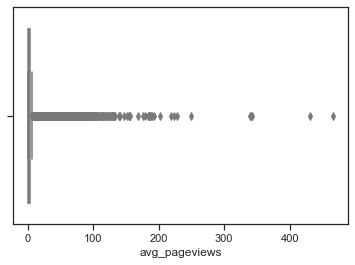

In [16]:
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="avg_pageviews", data=df.fillna(0))

In [17]:
df.loc[df.avg_pageviews>150,'avg_pageviews'].count()

24

In [18]:
df.loc[df.avg_pageviews>150,'outlier'] = 1

outlier for hit

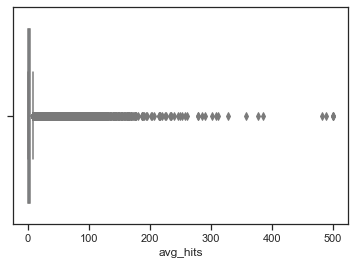

In [19]:
# hit
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="avg_hits", data=df)

In [20]:
df.loc[df.avg_hits>250,'avg_hits'].count()

19

In [21]:
df.loc[df.avg_hits>300,'outlier'] = 1

outlier for transaction

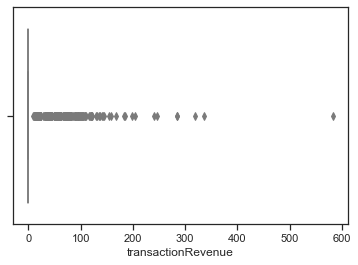

In [22]:
# transaction
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="transactionRevenue", data=df)

In [23]:
df.loc[df.transactionRevenue>100,'transactionRevenue'].count()

39

In [24]:
df.loc[df.transactionRevenue>100,'outlier'] = 1

outlier for bounce

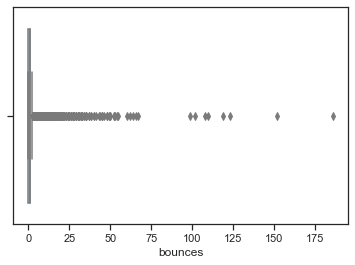

In [25]:
# bounce
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="bounces", data=df)

In [26]:
df.loc[df.bounces>75,'avg_hits'].count()

8

In [27]:
df.loc[df.bounces>75,'outlier'] = 1

outlier for visitnumber

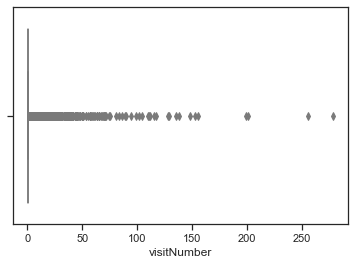

In [28]:
# visit number
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="visitNumber", data=df)

In [29]:
df.loc[df.visitNumber>150,'avg_hits'].count()

6

In [30]:
df.loc[df.visitNumber>150,'outlier'] = 1

In [31]:
df.loc[df['outlier']== 1,:]

,fullVisitorId,avg_hits,avg_pageviews,bounces,newVisits,fake_traffic,ctadwords,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,...,visit_hour_18,visit_hour_19,visit_hour_20,visit_hour_21,visit_hour_22,visit_hour_23,visitNumber,fullVisitorId,transactionRevenue,outlier
10725,949718915643445721,1.070312,1.070312,119.0,0.0,0,5,0.0,128.0,0.0,...,8.0,8.0,3.0,9.0,5.0,6.0,128,0949718915643445721,0.000000,1
12758,3047413202770064139,261.000000,190.000000,0.0,1.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,3047413202770064139,0.000000,1
17934,5590743844926892757,31.031250,22.906250,2.0,0.0,0,0,0.0,32.0,0.0,...,2.0,4.0,2.0,0.0,0.0,0.0,32,5590743844926892757,118.911119,1
45650,8637158932301658318,308.000000,139.000000,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,8637158932301658318,17.034386,1
46024,2074164338647079047,16.206897,13.241379,2.0,0.0,0,0,0.0,29.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,29,2074164338647079047,103.394017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119000,9417857471295131045,43.500000,29.125000,0.0,1.0,0,0,0.0,16.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16,9417857471295131045,105.333464,1
119531,2920116282116200226,214.500000,187.500000,0.0,1.0,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2,2920116282116200226,18.302685,1
121322,1814166460229302850,61.066667,42.666667,1.0,1.0,0,0,0.0,9.0,0.0,...,1.0,2.0,3.0,1.0,0.0,2.0,15,1814166460229302850,143.686901,1
130184,9377429831454005466,32.785714,24.464286,5.0,0.0,0,1,0.0,1.0,0.0,...,2.0,1.0,2.0,3.0,0.0,0.0,28,9377429831454005466,167.865327,1


In [32]:
df_no_outlier = df.loc[df['outlier'] != 1,:]
df_no_outlier

,fullVisitorId,avg_hits,avg_pageviews,bounces,newVisits,fake_traffic,ctadwords,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,...,visit_hour_18,visit_hour_19,visit_hour_20,visit_hour_21,visit_hour_22,visit_hour_23,visitNumber,fullVisitorId,transactionRevenue,outlier
0,9199694249115427127,1.0,1.0,1.0,1.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,9199694249115427127,0.0,0
1,2226471173658525097,2.0,2.0,0.0,1.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,2226471173658525097,0.0,0
2,5690615457906521996,1.0,1.0,1.0,1.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,5690615457906521996,0.0,0
3,5231780110074309081,1.0,1.0,1.0,1.0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,5231780110074309081,0.0,0
4,3635150676929887362,1.0,1.0,1.0,1.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,3635150676929887362,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140866,6101580518102726838,1.0,1.0,1.0,1.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,6101580518102726838,0.0,0
140867,2024883168211453883,4.0,4.0,0.0,1.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,2024883168211453883,0.0,0
140868,2939123142374615906,29.0,24.0,0.0,1.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,2939123142374615906,0.0,0
140869,7790845970173649,15.0,12.0,0.0,1.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,007790845970173649,0.0,0


In [33]:
df_no_outlier = df_no_outlier.iloc[:,1:]

In [34]:
df_no_outlier.drop('outlier', axis = 1, inplace = True)
df_no_outlier

,avg_hits,avg_pageviews,bounces,newVisits,fake_traffic,ctadwords,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,...,visit_hour_17,visit_hour_18,visit_hour_19,visit_hour_20,visit_hour_21,visit_hour_22,visit_hour_23,visitNumber,fullVisitorId,transactionRevenue
0,1.0,1.0,1.0,1.0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,9199694249115427127,0.0
1,2.0,2.0,0.0,1.0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2226471173658525097,0.0
2,1.0,1.0,1.0,1.0,0,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5690615457906521996,0.0
3,1.0,1.0,1.0,1.0,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5231780110074309081,0.0
4,1.0,1.0,1.0,1.0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3635150676929887362,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140866,1.0,1.0,1.0,1.0,0,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,6101580518102726838,0.0
140867,4.0,4.0,0.0,1.0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2024883168211453883,0.0
140868,29.0,24.0,0.0,1.0,0,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2939123142374615906,0.0
140869,15.0,12.0,0.0,1.0,0,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,007790845970173649,0.0


In [35]:
df_no_outlier.set_index('fullVisitorId', inplace = True)

y = df_no_outlier.pop('transactionRevenue')
X = df_no_outlier

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [336]:
X_train.to_csv('X_train_no_outlier.csv')
X_test.to_csv('X_test_no_outlier.csv')
y_train.to_csv('y_train_no_outlier.csv')
y_test.to_csv('y_test_no_outlier.csv')

/Users/jiahui/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jiahui/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


# EDA

In [32]:
### all data before getting dummy
all_flatten = pd.read_csv('all_flatten_data.csv')

/Users/jiahui/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
all_flatten.transactionRevenue = all_flatten.transactionRevenue.fillna(1)

In [34]:
import math
all_flatten['transactionRevenue'] = np.log(all_flatten['transactionRevenue'])

In [35]:
all_flatten.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,set,...,networkDomain,latitude,longitude,networkLocation,visits,hits,pageviews,bounces,newVisits,transactionRevenue
0,0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,train,...,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,0.0
1,0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,test,...,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,0.0
2,1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,train,...,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,0.0
3,1,Organic Search,20171016,643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,test,...,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,0.0
4,2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,train,...,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,0.0


# group channel

In [36]:
channelGrouping_session = all_flatten.loc[all_flatten.set == 'train',['fullVisitorId','channelGrouping', 'transactionRevenue']]


In [38]:
groupy_channelGrouping_visitor = channelGrouping_session.groupby(['fullVisitorId','channelGrouping']).sum().reset_index()
groupy_channelGrouping_visitor
#groupy_channelGrouping_visitor.groupby('channelGrouping').sum()

,fullVisitorId,channelGrouping,transactionRevenue
0,4823595352351,Organic Search,0.0
1,5103959234087,Organic Search,0.0
2,20424342248747,Organic Search,0.0
3,26722803385797,Organic Search,0.0
4,33471059618621,Social,0.0
5,35794135966385,Direct,0.0
6,47810105303746,Direct,0.0
7,48421062322244,Direct,0.0
8,52246474382344,Social,0.0
9,58970809397690,Organic Search,0.0


In [39]:
channle_visitor_summary = groupy_channelGrouping_visitor.groupby('channelGrouping').agg({'fullVisitorId': 'count', 'transactionRevenue': 'sum'})
channle_visitor_summary['Unique'] = 'visitor'
channle_visitor_summary

,fullVisitorId,transactionRevenue,Unique
channelGrouping,,,
(Other),95,16.117095,visitor
Affiliates,13756,154.277370,visitor
Direct,113725,36825.206010,visitor
Display,4352,2611.813070,visitor
Organic Search,320804,60427.851806,visitor
Paid Search,19453,8244.459896,visitor
Referral,70942,95152.014363,visitor
Social,214606,1804.276756,visitor


In [40]:
channel_session_summary = channelGrouping_session.groupby('channelGrouping').agg({'fullVisitorId':'count','transactionRevenue': 'sum'})
#groupy_channelGrouping.reset_index(inplace = True)
channel_session_summary['Unique']='session'
channel_session_summary

,fullVisitorId,transactionRevenue,Unique
channelGrouping,,,
(Other),120,16.117095,session
Affiliates,16403,154.277370,session
Direct,143026,36825.206010,session
Display,6262,2611.813070,session
Organic Search,381561,60427.851806,session
Paid Search,25326,8244.459896,session
Referral,104838,95152.014363,session
Social,226117,1804.276756,session


In [41]:
channel_whole_summary = pd.concat([channle_visitor_summary, channel_session_summary])
channel_whole_summary.reset_index(inplace=True)
channel_whole_summary

,channelGrouping,fullVisitorId,transactionRevenue,Unique
0,(Other),95,16.117095,visitor
1,Affiliates,13756,154.277370,visitor
2,Direct,113725,36825.206010,visitor
3,Display,4352,2611.813070,visitor
4,Organic Search,320804,60427.851806,visitor
5,Paid Search,19453,8244.459896,visitor
6,Referral,70942,95152.014363,visitor
7,Social,214606,1804.276756,visitor
8,(Other),120,16.117095,session
9,Affiliates,16403,154.277370,session


/Users/jiahui/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Transaction Revunue by Channle')

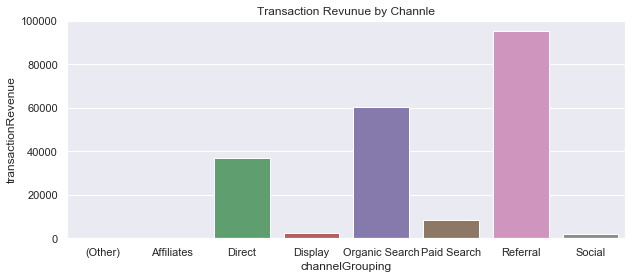

In [42]:
sns.set()
plt.figure(figsize=(10,4))
channel_freq = sns.barplot(x="channelGrouping", y="transactionRevenue", data=channel_whole_summary)
plt.title("Transaction Revunue by Channle")

Text(0.5, 1.0, 'Total Visits by Channle')

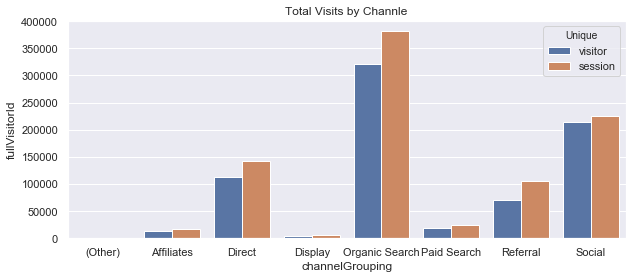

In [43]:
sns.set()
plt.figure(figsize=(10,4))
channel_freq = sns.barplot(x="channelGrouping", y="fullVisitorId", hue="Unique", data=channel_whole_summary)
plt.title("Total Visits by Channle")

Text(0.5, 1.0, 'Channel grouping distribution')

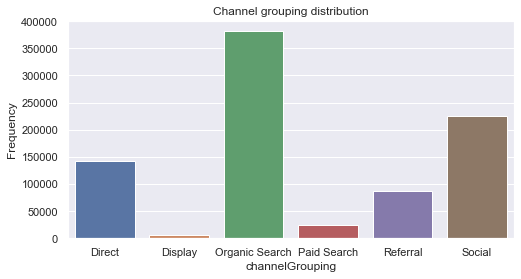

In [151]:
# sns.set()
# plt.figure(figsize=(8,4))
# channelGrouping_plot = sns.barplot(x="channelGrouping", y="Frequency", data=channelGrouping_freq)
# plt.title("Channel grouping distribution")
# #medium_plot.set_xticklabels(medium_plot.get_xticklabels(), rotation=-45)

# Browser

In [359]:
browser_session = all_flatten.loc[all_flatten.set == 'train',['fullVisitorId','browser', 'transactionRevenue']]

In [360]:
browser_session.browser.unique()
wanted_browser = ['Edge', 'Chrome', 'Firefox','Internet Explorer', 'Safari','Safari (in-app)']
browser_session['new_browser'] = [i if i in wanted_browser else 'other' for i in browser_session['browser']]

In [361]:
browser_groupby_session = browser_session.groupby('new_browser').agg({'fullVisitorId': 'count', 'transactionRevenue': 'sum'})
browser_groupby_session.reset_index(inplace=True)
browser_groupby_session['Unique'] = 'session'
browser_groupby_session

,new_browser,fullVisitorId,transactionRevenue,Unique
0,Chrome,620364,185086.754674,session
1,Edge,10205,1007.951558,session
2,Firefox,37069,3386.697671,session
3,Internet Explorer,19375,1899.524250,session
4,Safari,182245,13457.766652,session
5,Safari (in-app),6850,195.111335,session
6,other,27545,202.210229,session


In [362]:
groupy_browser_visitor = browser_session.groupby(['fullVisitorId','new_browser']).sum().reset_index()
groupy_browser_visitor['Unique'] = 'visitor'
groupy_browser_visitor

,fullVisitorId,new_browser,transactionRevenue,Unique
0,4823595352351,Chrome,0.0,visitor
1,5103959234087,Chrome,0.0,visitor
2,20424342248747,Chrome,0.0,visitor
3,26722803385797,Safari,0.0,visitor
4,33471059618621,Safari,0.0,visitor
...,...,...,...,...
737917,999964306551258242,Chrome,0.0,visitor
737918,9999679083512798585,Chrome,0.0,visitor
737919,9999691889975139507,Firefox,0.0,visitor
737920,9999739624339618281,Firefox,0.0,visitor


In [363]:
browser_visitor_summary = groupy_browser_visitor.groupby('new_browser').agg({'fullVisitorId': 'count', 'transactionRevenue': 'sum'})
browser_visitor_summary['Unique'] = 'visitor'
browser_visitor_summary.reset_index(inplace=True)

In [364]:
browser_all = pd.concat([browser_groupby_session,browser_visitor_summary])
browser_all

,new_browser,fullVisitorId,transactionRevenue,Unique
0,Chrome,620364,185086.754674,session
1,Edge,10205,1007.951558,session
2,Firefox,37069,3386.697671,session
3,Internet Explorer,19375,1899.524250,session
4,Safari,182245,13457.766652,session
5,Safari (in-app),6850,195.111335,session
6,other,27545,202.210229,session
0,Chrome,487032,185086.754674,visitor
1,Edge,9023,1007.951558,visitor
2,Firefox,32050,3386.697671,visitor


Text(0.5, 1.0, 'Total Visits by Browser')

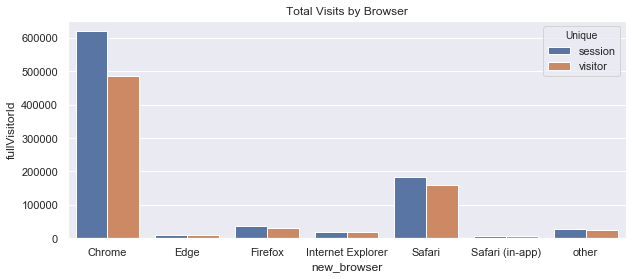

In [365]:
sns.set()
plt.figure(figsize=(10,4))
channel_freq = sns.barplot(x="new_browser", y="fullVisitorId", hue="Unique", data=browser_all)
plt.title("Total Visits by Browser")

Text(0.5, 1.0, 'Transaction Revunue by Browser')

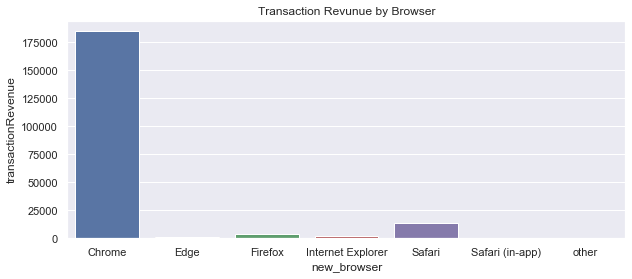

In [366]:
sns.set()
plt.figure(figsize=(10,4))
browser_plot = sns.barplot(x="new_browser", y="transactionRevenue",data=browser_all)
plt.title("Transaction Revunue by Browser")

In [367]:
browser_session['new_browser'].unique()
browser_session.groupby('new_browser').browser.count()

new_browser
Chrome               620364
Edge                  10205
Firefox               37069
Internet Explorer     19375
Safari               182245
Safari (in-app)        6850
other                 27545
Name: browser, dtype: int64

# Subcontinant

In [368]:
subcontinent_session = all_flatten.loc[all_flatten.set == 'train',['fullVisitorId','subContinent', 'transactionRevenue']].fillna(0)
subcontinent_session.head()

,fullVisitorId,subContinent,transactionRevenue
0,1131660440785968503,Western Asia,0.0
2,377306020877927890,Australasia,0.0
4,3895546263509774583,Southern Europe,0.0
6,4763447161404445595,Southeast Asia,0.0
8,27294437909732085,Northern Europe,0.0


In [369]:
subcontinent_groupby_session = subcontinent_session.groupby('subContinent').agg({'fullVisitorId': 'count', 'transactionRevenue': 'sum'})
subcontinent_groupby_session.reset_index(inplace=True)
subcontinent_groupby_session['Unique'] = 'session'
subcontinent_groupby_session

,subContinent,fullVisitorId,transactionRevenue,Unique
0,(not set),1468,109.252305,session
1,Australasia,14893,253.468862,session
2,Caribbean,2406,282.023106,session
3,Central America,15583,461.008275,session
4,Central Asia,1215,33.205644,session
5,Eastern Africa,1927,63.844716,session
6,Eastern Asia,46919,1065.426948,session
7,Eastern Europe,45249,241.828893,session
8,Melanesia,81,0.000000,session
9,Micronesian Region,55,0.000000,session


In [370]:
groupy_subContinent_visitor = subcontinent_session.groupby(['fullVisitorId','subContinent']).sum().reset_index()
groupy_subContinent_visitor

,fullVisitorId,subContinent,transactionRevenue
0,4823595352351,Eastern Asia,0.0
1,5103959234087,Northern America,0.0
2,20424342248747,South America,0.0
3,26722803385797,Northern Europe,0.0
4,33471059618621,Western Asia,0.0
...,...,...,...
739198,999964306551258242,Eastern Europe,0.0
739199,9999679083512798585,(not set),0.0
739200,9999691889975139507,Eastern Asia,0.0
739201,9999739624339618281,Northern America,0.0


In [371]:
subcontinent_groupby = groupy_subContinent_visitor.groupby('subContinent').agg({'fullVisitorId': 'count', 'transactionRevenue': 'sum'})
subcontinent_groupby.reset_index(inplace=True)
subcontinent_groupby['Unique'] = 'Visitor'
subcontinent_groupby


,subContinent,fullVisitorId,transactionRevenue,Unique
0,(not set),1370,109.252305,Visitor
1,Australasia,13056,253.468862,Visitor
2,Caribbean,2081,282.023106,Visitor
3,Central America,13900,461.008275,Visitor
4,Central Asia,1148,33.205644,Visitor
5,Eastern Africa,1764,63.844716,Visitor
6,Eastern Asia,38879,1065.426948,Visitor
7,Eastern Europe,40598,241.828893,Visitor
8,Melanesia,73,0.000000,Visitor
9,Micronesian Region,49,0.000000,Visitor


In [372]:
subcontinent_all = pd.concat([subcontinent_groupby_session,subcontinent_groupby])

[Text(0, 0, '(not set)'),
 Text(0, 0, 'Australasia'),
 Text(0, 0, 'Caribbean'),
 Text(0, 0, 'Central America'),
 Text(0, 0, 'Central Asia'),
 Text(0, 0, 'Eastern Africa'),
 Text(0, 0, 'Eastern Asia'),
 Text(0, 0, 'Eastern Europe'),
 Text(0, 0, 'Melanesia'),
 Text(0, 0, 'Micronesian Region'),
 Text(0, 0, 'Middle Africa'),
 Text(0, 0, 'Northern Africa'),
 Text(0, 0, 'Northern America'),
 Text(0, 0, 'Northern Europe'),
 Text(0, 0, 'Polynesia'),
 Text(0, 0, 'South America'),
 Text(0, 0, 'Southeast Asia'),
 Text(0, 0, 'Southern Africa'),
 Text(0, 0, 'Southern Asia'),
 Text(0, 0, 'Southern Europe'),
 Text(0, 0, 'Western Africa'),
 Text(0, 0, 'Western Asia'),
 Text(0, 0, 'Western Europe')]

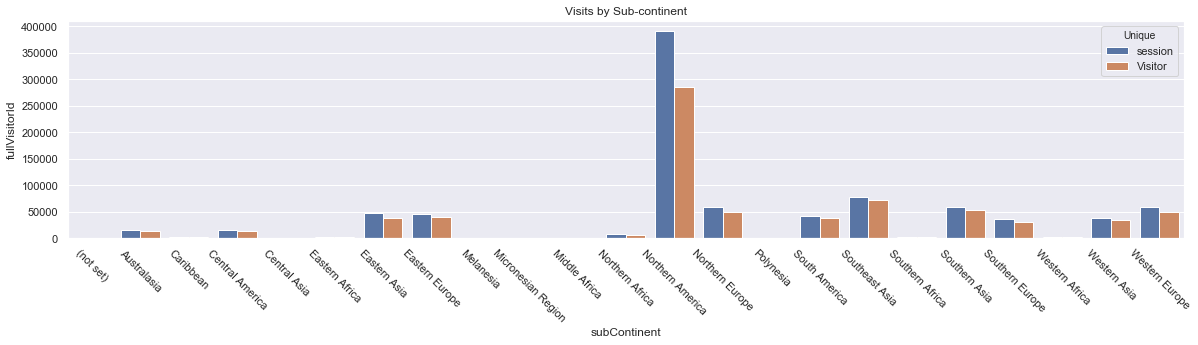

In [373]:
sns.set()
plt.figure(figsize=(20,4))
subcontinent_plot = sns.barplot(x="subContinent", y="fullVisitorId", hue = 'Unique', data=subcontinent_all)
plt.title("Visits by Sub-continent")
subcontinent_plot.set_xticklabels(subcontinent_plot.get_xticklabels(), rotation=-45)

[Text(0, 0, '(not set)'),
 Text(0, 0, 'Australasia'),
 Text(0, 0, 'Caribbean'),
 Text(0, 0, 'Central America'),
 Text(0, 0, 'Central Asia'),
 Text(0, 0, 'Eastern Africa'),
 Text(0, 0, 'Eastern Asia'),
 Text(0, 0, 'Eastern Europe'),
 Text(0, 0, 'Melanesia'),
 Text(0, 0, 'Micronesian Region'),
 Text(0, 0, 'Middle Africa'),
 Text(0, 0, 'Northern Africa'),
 Text(0, 0, 'Northern America'),
 Text(0, 0, 'Northern Europe'),
 Text(0, 0, 'Polynesia'),
 Text(0, 0, 'South America'),
 Text(0, 0, 'Southeast Asia'),
 Text(0, 0, 'Southern Africa'),
 Text(0, 0, 'Southern Asia'),
 Text(0, 0, 'Southern Europe'),
 Text(0, 0, 'Western Africa'),
 Text(0, 0, 'Western Asia'),
 Text(0, 0, 'Western Europe')]

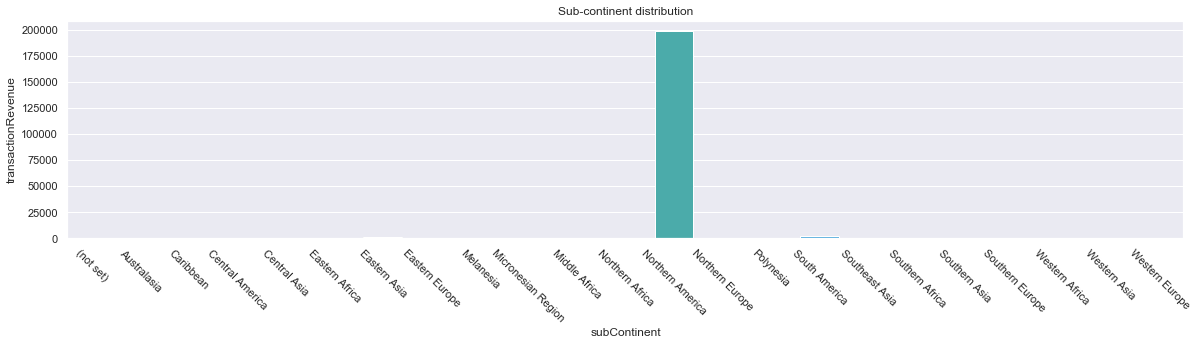

In [374]:
sns.set()
plt.figure(figsize=(20,4))
subcontinent_plot = sns.barplot(x="subContinent", y="transactionRevenue", data=subcontinent_all)
plt.title("Sub-continent distribution")
subcontinent_plot.set_xticklabels(subcontinent_plot.get_xticklabels(), rotation=-45)

# operatingSystem

In [375]:
operatingSystem_session = all_flatten.loc[all_flatten.set == 'train',['fullVisitorId','operatingSystem', 'transactionRevenue']].fillna(0)
operatingSystem_session.head()

,fullVisitorId,operatingSystem,transactionRevenue
0,1131660440785968503,Windows,0.0
2,377306020877927890,Macintosh,0.0
4,3895546263509774583,Windows,0.0
6,4763447161404445595,Linux,0.0
8,27294437909732085,Android,0.0


In [377]:
operatingSystem_groupby_session = operatingSystem_session.groupby('operatingSystem').agg({'fullVisitorId': 'count', 'transactionRevenue': 'sum'})
operatingSystem_groupby_session.reset_index(inplace=True)
operatingSystem_groupby_session['Unique'] = 'session'
operatingSystem_groupby_session

,operatingSystem,fullVisitorId,transactionRevenue,Unique
0,(not set),4695,0.000000,session
1,Android,123892,8065.216154,session
2,BlackBerry,218,0.000000,session
3,Chrome OS,26337,18104.075086,session
4,Firefox OS,89,0.000000,session
5,FreeBSD,9,0.000000,session
6,Linux,35034,13665.501362,session
7,Macintosh,253938,115248.854091,session
8,NTT DoCoMo,1,0.000000,session
9,Nintendo 3DS,1,0.000000,session


In [379]:
groupy_operatingSystem_visitor = operatingSystem_session.groupby(['fullVisitorId','operatingSystem']).sum().reset_index()
groupy_operatingSystem_visitor

,fullVisitorId,operatingSystem,transactionRevenue
0,4823595352351,Windows,0.0
1,5103959234087,Android,0.0
2,20424342248747,Windows,0.0
3,26722803385797,Macintosh,0.0
4,33471059618621,Macintosh,0.0
...,...,...,...
738003,999964306551258242,Windows,0.0
738004,9999679083512798585,(not set),0.0
738005,9999691889975139507,Windows,0.0
738006,9999739624339618281,Macintosh,0.0


In [380]:
operatingSystem_groupby = groupy_operatingSystem_visitor.groupby('operatingSystem').agg({'fullVisitorId': 'count', 'transactionRevenue': 'sum'})
operatingSystem_groupby.reset_index(inplace=True)
operatingSystem_groupby['Unique'] = 'Visitor'
operatingSystem_groupby

,operatingSystem,fullVisitorId,transactionRevenue,Unique
0,(not set),4435,0.000000,Visitor
1,Android,101711,8065.216154,Visitor
2,BlackBerry,210,0.000000,Visitor
3,Chrome OS,18485,18104.075086,Visitor
4,Firefox OS,83,0.000000,Visitor
5,FreeBSD,9,0.000000,Visitor
6,Linux,26582,13665.501362,Visitor
7,Macintosh,196400,115248.854091,Visitor
8,NTT DoCoMo,1,0.000000,Visitor
9,Nintendo 3DS,1,0.000000,Visitor


In [383]:
operatingSystem_all = pd.concat([operatingSystem_groupby_session,operatingSystem_groupby])
operatingSystem_all

,operatingSystem,fullVisitorId,transactionRevenue,Unique
0,(not set),4695,0.000000,session
1,Android,123892,8065.216154,session
2,BlackBerry,218,0.000000,session
3,Chrome OS,26337,18104.075086,session
4,Firefox OS,89,0.000000,session
5,FreeBSD,9,0.000000,session
6,Linux,35034,13665.501362,session
7,Macintosh,253938,115248.854091,session
8,NTT DoCoMo,1,0.000000,session
9,Nintendo 3DS,1,0.000000,session


[Text(0, 0, '(not set)'),
 Text(0, 0, 'Android'),
 Text(0, 0, 'BlackBerry'),
 Text(0, 0, 'Chrome OS'),
 Text(0, 0, 'Firefox OS'),
 Text(0, 0, 'FreeBSD'),
 Text(0, 0, 'Linux'),
 Text(0, 0, 'Macintosh'),
 Text(0, 0, 'NTT DoCoMo'),
 Text(0, 0, 'Nintendo 3DS'),
 Text(0, 0, 'Nintendo Wii'),
 Text(0, 0, 'Nintendo WiiU'),
 Text(0, 0, 'Nokia'),
 Text(0, 0, 'OpenBSD'),
 Text(0, 0, 'Samsung'),
 Text(0, 0, 'SunOS'),
 Text(0, 0, 'Windows'),
 Text(0, 0, 'Windows Phone'),
 Text(0, 0, 'Xbox'),
 Text(0, 0, 'iOS')]

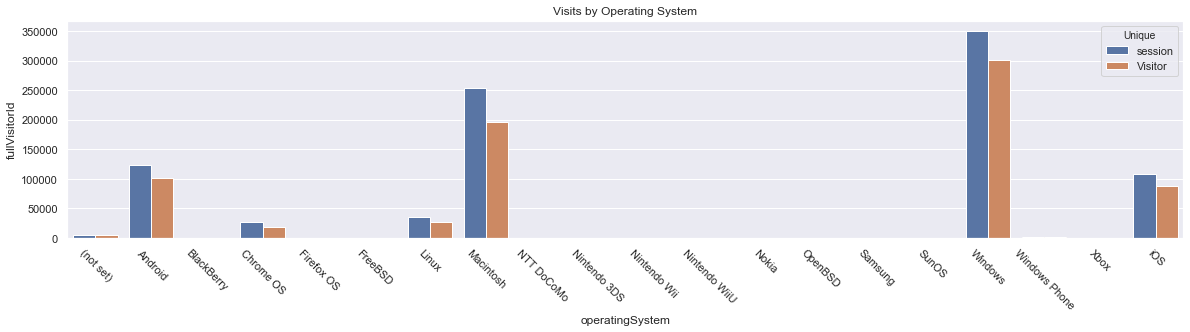

In [385]:
sns.set()
plt.figure(figsize=(20,4))
operatingSystem_plot = sns.barplot(x="operatingSystem", y="fullVisitorId", hue = 'Unique',data=operatingSystem_all)
plt.title("Visits by Operating System")
operatingSystem_plot.set_xticklabels(operatingSystem_plot.get_xticklabels(), rotation=-45)

[Text(0, 0, '(not set)'),
 Text(0, 0, 'Android'),
 Text(0, 0, 'BlackBerry'),
 Text(0, 0, 'Chrome OS'),
 Text(0, 0, 'Firefox OS'),
 Text(0, 0, 'FreeBSD'),
 Text(0, 0, 'Linux'),
 Text(0, 0, 'Macintosh'),
 Text(0, 0, 'NTT DoCoMo'),
 Text(0, 0, 'Nintendo 3DS'),
 Text(0, 0, 'Nintendo Wii'),
 Text(0, 0, 'Nintendo WiiU'),
 Text(0, 0, 'Nokia'),
 Text(0, 0, 'OpenBSD'),
 Text(0, 0, 'Samsung'),
 Text(0, 0, 'SunOS'),
 Text(0, 0, 'Windows'),
 Text(0, 0, 'Windows Phone'),
 Text(0, 0, 'Xbox'),
 Text(0, 0, 'iOS')]

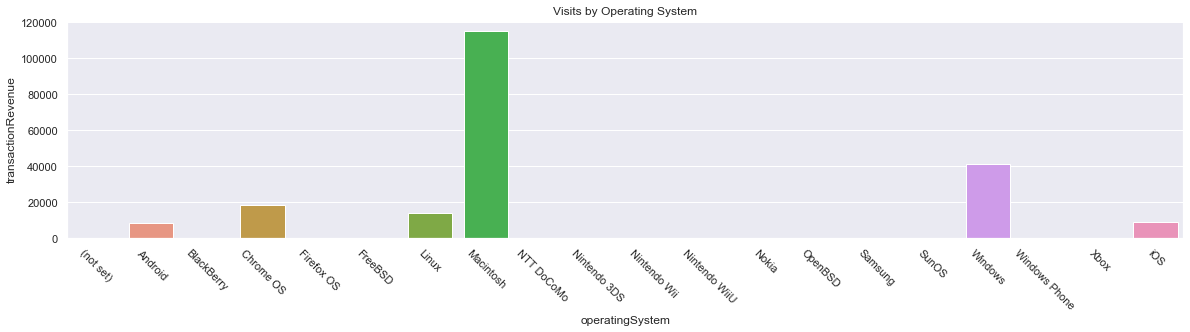

In [387]:
sns.set()
plt.figure(figsize=(20,4))
operatingSystem_plot = sns.barplot(x="operatingSystem", y="transactionRevenue", data=operatingSystem_all)
plt.title("Visits by Operating System")
operatingSystem_plot.set_xticklabels(operatingSystem_plot.get_xticklabels(), rotation=-45)

# deviceCategory_tablet

In [396]:
device_session = all_flatten.loc[all_flatten.set == 'train',['fullVisitorId','deviceCategory', 'transactionRevenue']].fillna(0)
device_session.head()

,fullVisitorId,deviceCategory,transactionRevenue
0,1131660440785968503,desktop,0.0
2,377306020877927890,desktop,0.0
4,3895546263509774583,desktop,0.0
6,4763447161404445595,desktop,0.0
8,27294437909732085,mobile,0.0


In [397]:
device_groupby_session = device_session.groupby('deviceCategory').agg({'fullVisitorId': 'count', 'transactionRevenue': 'sum'})
device_groupby_session.reset_index(inplace=True)
device_groupby_session['Unique'] = 'session'
device_groupby_session

,deviceCategory,fullVisitorId,transactionRevenue,Unique
0,desktop,664479,187728.140855,session
1,mobile,208725,14587.387484,session
2,tablet,30449,2920.488029,session


In [398]:
groupy_device_visitor = device_session.groupby(['fullVisitorId','deviceCategory']).sum().reset_index()
groupy_device_visitor

,fullVisitorId,deviceCategory,transactionRevenue
0,4823595352351,desktop,0.0
1,5103959234087,mobile,0.0
2,20424342248747,desktop,0.0
3,26722803385797,desktop,0.0
4,33471059618621,desktop,0.0
...,...,...,...
737787,999964306551258242,desktop,0.0
737788,9999679083512798585,desktop,0.0
737789,9999691889975139507,desktop,0.0
737790,9999739624339618281,desktop,0.0


In [399]:
device_groupby = groupy_device_visitor.groupby('deviceCategory').agg({'fullVisitorId': 'count', 'transactionRevenue': 'sum'})
device_groupby.reset_index(inplace=True)
device_groupby['Unique'] = 'Visitor'
device_groupby

,deviceCategory,fullVisitorId,transactionRevenue,Unique
0,desktop,541375,187728.140855,Visitor
1,mobile,171273,14587.387484,Visitor
2,tablet,25144,2920.488029,Visitor


In [400]:
device_all = pd.concat([device_groupby_session,device_groupby])

Text(0.5, 1.0, 'Visits by Device')

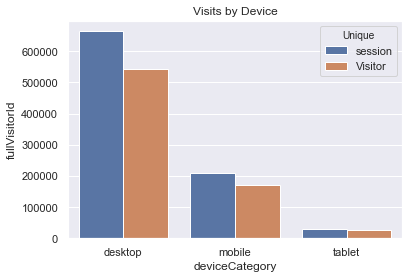

In [401]:
sns.set()
plt.figure(figsize=(6,4))
device_plot = sns.barplot(x="deviceCategory", y="fullVisitorId", hue = 'Unique',data=device_all)
plt.title("Visits by Device")
#device_plot.set_xticklabels(device_plot.get_xticklabels(), rotation=-45)

Text(0.5, 1.0, 'Transactions by Device')

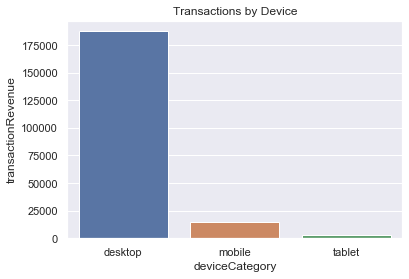

In [402]:
sns.set()
plt.figure(figsize=(6,4))
device_plot = sns.barplot(x="deviceCategory", y="transactionRevenue", data=device_all)
plt.title("Transactions by Device")
#device_plot.set_xticklabels(device_plot.get_xticklabels(), rotation=-45)

# weekdays_Saturday

In [404]:
weekdays_session = all_flatten.loc[all_flatten.set == 'train',['fullVisitorId','date', 'transactionRevenue']].fillna(0)
weekdays_session.head()
import datetime
weekdays_session['weekdays'] = [datetime.datetime.strptime(i, '%Y%m%d').strftime('%A') for i in weekdays_session['date'].astype(str).values]

In [405]:
weekdays_groupby_session = weekdays_session.groupby('weekdays').agg({'fullVisitorId': 'count', 'transactionRevenue': 'sum'})
weekdays_groupby_session.reset_index(inplace=True)
weekdays_groupby_session['Unique'] = 'session'
weekdays_groupby_session

,weekdays,fullVisitorId,transactionRevenue,Unique
0,Friday,128331,33546.750418,session
1,Monday,140905,36706.192175,session
2,Saturday,97646,13678.827012,session
3,Sunday,100360,16623.481201,session
4,Thursday,142399,33991.186961,session
5,Tuesday,147279,36189.405756,session
6,Wednesday,146733,34500.172845,session


In [406]:
groupy_weekdays_visitor = weekdays_session.groupby(['fullVisitorId','weekdays']).sum().reset_index()
groupy_weekdays_visitor

,fullVisitorId,weekdays,date,transactionRevenue
0,4823595352351,Tuesday,20161101,0.0
1,5103959234087,Sunday,20160821,0.0
2,20424342248747,Wednesday,20161130,0.0
3,26722803385797,Monday,20170605,0.0
4,33471059618621,Sunday,20161127,0.0
...,...,...,...,...
812048,999964306551258242,Monday,20170417,0.0
812049,9999679083512798585,Friday,20170210,0.0
812050,9999691889975139507,Thursday,20160825,0.0
812051,9999739624339618281,Friday,20170210,0.0


In [407]:
weekdays_groupby = groupy_weekdays_visitor.groupby('weekdays').agg({'fullVisitorId': 'count', 'transactionRevenue': 'sum'})
weekdays_groupby.reset_index(inplace=True)
weekdays_groupby['Unique'] = 'Visitor'
weekdays_groupby

,weekdays,fullVisitorId,transactionRevenue,Unique
0,Friday,115042,33546.750418,Visitor
1,Monday,125824,36706.192175,Visitor
2,Saturday,89962,13678.827012,Visitor
3,Sunday,92212,16623.481201,Visitor
4,Thursday,127741,33991.186961,Visitor
5,Tuesday,131090,36189.405756,Visitor
6,Wednesday,130182,34500.172845,Visitor


In [408]:
weekdays_all = pd.concat([weekdays_groupby_session,weekdays_groupby])

Text(0.5, 1.0, 'Visits by Weekdays')

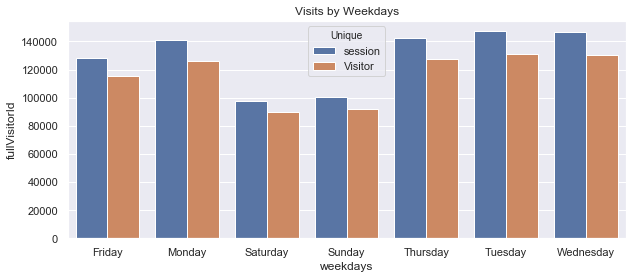

In [411]:
sns.set()
plt.figure(figsize=(10,4))
device_plot = sns.barplot(x="weekdays", y="fullVisitorId", hue = 'Unique',data=weekdays_all)
plt.title("Visits by Weekdays")
#device_plot.set_xticklabels(device_plot.get_xticklabels(), rotation=-45)

Text(0.5, 1.0, 'Transactions by Weekdays')

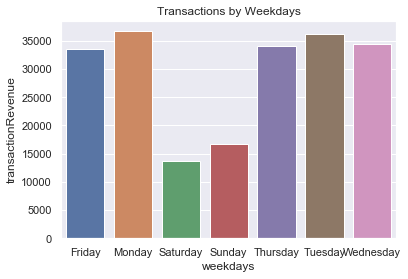

In [410]:
sns.set()
plt.figure(figsize=(6,4))
device_plot = sns.barplot(x="weekdays", y="transactionRevenue", data=weekdays_all)
plt.title("Transactions by Weekdays")
#device_plot.set_xticklabels(device_plot.get_xticklabels(), rotation=-45)

# visit_hour_3

In [412]:
hour_session = all_flatten.loc[all_flatten.set == 'train',['fullVisitorId','visitStartTime', 'transactionRevenue']].fillna(0)
hour_session['visit_hour'] = [datetime.datetime.fromtimestamp(i).hour for i in hour_session.visitStartTime]
hour_session.head()

,fullVisitorId,visitStartTime,transactionRevenue,visit_hour
0,1131660440785968503,1472830385,0.0,10
2,377306020877927890,1472880147,0.0,0
4,3895546263509774583,1472865386,0.0,20
6,4763447161404445595,1472881213,0.0,0
8,27294437909732085,1472822600,0.0,8


In [413]:
hour_groupby_session = hour_session.groupby('visit_hour').agg({'fullVisitorId': 'count', 'transactionRevenue': 'sum'})
hour_groupby_session.reset_index(inplace=True)
hour_groupby_session['Unique'] = 'session'
hour_groupby_session

,visit_hour,fullVisitorId,transactionRevenue,Unique
0,0,29314,4386.069230,session
1,1,29710,1719.782814,session
2,2,31791,2119.200303,session
3,3,30601,898.338115,session
4,4,30425,914.914133,session
5,5,29695,762.873786,session
6,6,31944,1602.967153,session
7,7,36255,3386.149412,session
8,8,41792,6992.758291,session
9,9,45842,10752.738819,session


In [415]:
groupy_hour_visitor = hour_session.groupby(['fullVisitorId','visit_hour']).sum().reset_index()
groupy_hour_visitor

,fullVisitorId,visit_hour,visitStartTime,transactionRevenue
0,4823595352351,9,1478011510,0.0
1,5103959234087,17,1471817208,0.0
2,20424342248747,1,1480578901,0.0
3,26722803385797,5,1496658394,0.0
4,33471059618621,17,1480289088,0.0
...,...,...,...,...
864303,999964306551258242,6,1492427704,0.0
864304,9999679083512798585,12,1486751068,0.0
864305,9999691889975139507,0,1472190733,0.0
864306,9999739624339618281,12,1486752874,0.0


In [416]:
hour_groupby = groupy_hour_visitor.groupby('visit_hour').agg({'fullVisitorId': 'count', 'transactionRevenue': 'sum'})
hour_groupby.reset_index(inplace=True)
hour_groupby['Unique'] = 'Visitor'
hour_groupby

,visit_hour,fullVisitorId,transactionRevenue,Unique
0,0,28320,4386.069230,Visitor
1,1,28713,1719.782814,Visitor
2,2,30694,2119.200303,Visitor
3,3,29610,898.338115,Visitor
4,4,29518,914.914133,Visitor
5,5,28957,762.873786,Visitor
6,6,31021,1602.967153,Visitor
7,7,35028,3386.149412,Visitor
8,8,39928,6992.758291,Visitor
9,9,43731,10752.738819,Visitor


In [420]:
hour_all = pd.concat([hour_groupby_session,hour_groupby])

Text(0.5, 1.0, 'Visits by Hour')

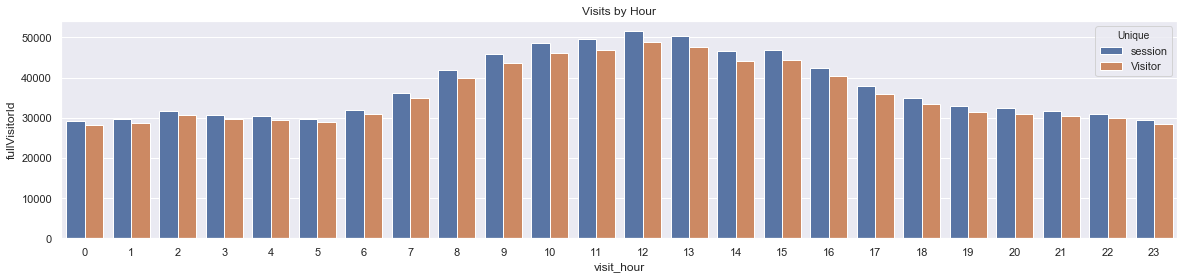

In [423]:
sns.set()
plt.figure(figsize=(20,4))
hour_plot = sns.barplot(x="visit_hour", y="fullVisitorId", hue = 'Unique',data=hour_all)
plt.title("Visits by Hour")
#device_plot.set_xticklabels(device_plot.get_xticklabels(), rotation=-45)

Text(0.5, 1.0, 'Transactions by Hour')

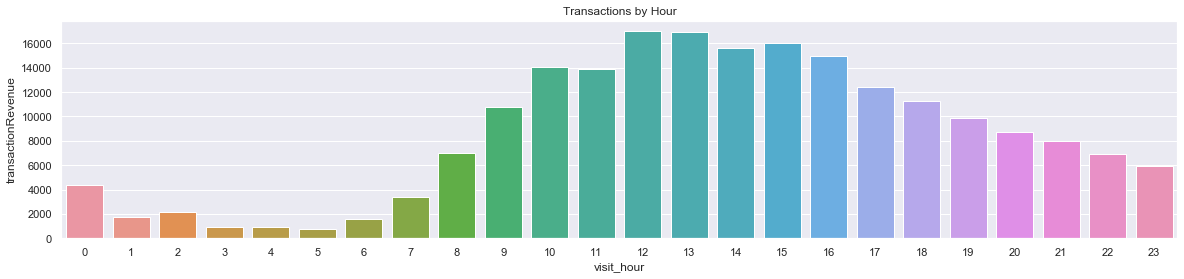

In [424]:
sns.set()
plt.figure(figsize=(20,4))
hour_plot = sns.barplot(x="visit_hour", y="transactionRevenue",data=hour_all)
plt.title("Transactions by Hour")
#device_plot.set_xticklabels(device_plot.get_xticklabels(), rotation=-45)